### 环境搭建

- pip install pygame

使用https://github.com/sourabhv/FlapPyBird 项目，在本地运行游戏。

### 原理简述

- State（ S  ）：环境的状态，例如FlappyBird中的当前游戏界面
    - 一张图片包含的信息
- Action（ A ）：每个 S 下可采取的行动集合，例如在FlappyBird中可选择两个 A   
    - 跳一下
    - 什么都不做
- Reward（ R ）：在某个 S 下执行某个 A 之后得到的回报，例如在FlappyBird中
    - 成功跳过一根水管（正回报）
    - 撞到水管或者掉到地上（负回报）

游戏过程表示为：
$$
s_{0}, a_{0}, r_{1}, s_{1}, a_{1}, r_{2}, s_{2}, \dots, s_{n-1}, a_{n-1}, r_{n}, s_{n}
$$
某一个时刻的R，表示为：
$$
R_{t}=r_{t}+\gamma r_{t+1}+\gamma^{2} r_{t+2}+\ldots+\gamma^{n-t} r_{n}
$$
其中$\gamma$为对未来不确定性的估计，乘上权重衰减系数。

则递推关系表示为：
$$
R_{t}=r_{t}+\gamma R_{t+1}
$$

训练目标是未来收益最大，那么定义Q（Quality，价值函数），作为对未来的度量：
$$
Q\left(s_{t}, a_{t}\right)=\max R_{t+1}
$$

训练的最终目的是找到最优的决策序列，即在 s 状态下，使Q最大的 a：
$$
\pi(s)=\operatorname{argmax}_{a} Q(s, a)
$$



当Q收敛时，论文中给出以下关系：

$$
Q\left(s_{t}, a_{t}\right)=r_{t}+\gamma \max Q\left(s_{t+1}, a_{t+1}\right)
$$

这个关系，可以用来计算类似常规神经网络中的 {Network(X),  Y}之间的error。然后BP更新网络参数。
直到该关系式收敛。代码中，Y代表等式左边，Q_代表等式右边

Q函数使用神经网络表示，输入是图像，输出价值度量。
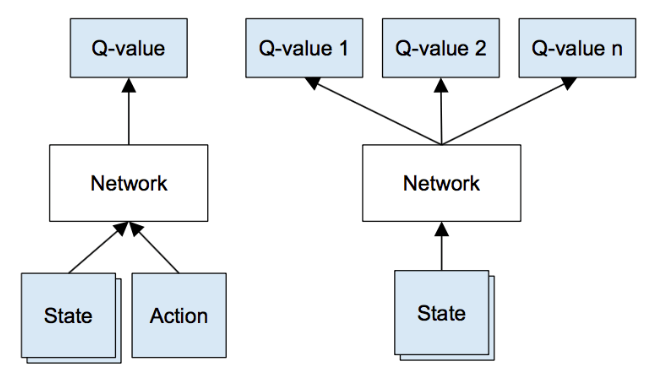

训练方法：
- 输入S，每个可能的A都对应一个输出结果Q值
- 随机探索（以一定概率随机选择）和有向策略（使用策略函数选择）相结合，选择A，
- 维护一个memory，储存游戏过程积累中间数据（经验）

训练流程：
- 预热期：以随机概率选择A，不更新Q函数，产生必要数量的memory数据
- 探索期：逐渐降低随机概率，从随机探索过渡到有向策略，并且每次从记忆模块中取出一些数据训练模型
- 训练期：固定随机概率，进一步训练模型，使得Q函数进一步收敛


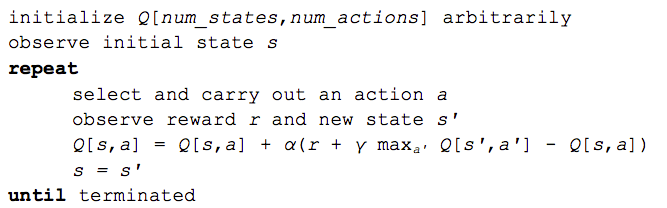

### Code

参考代码 https://github.com/yenchenlin/DeepLearningFlappyBird

In [2]:
import tensorflow as tf
import numpy as np
import random
import cv2
import sys
sys.path.append('game/')  # for import wrapped_flappy_bird：model file
import wrapped_flappy_bird as fb
from collections import deque  # for memory

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
ACTIONS = 2  # A可能取值
GAMMA = 0.99  # 衰减权重
OBSERVE = 10000  # 预热训练轮次
EXPLORE = 3000000  # 探索期训练轮次
INITIAL_EPSILON = 0.1  # 随机探索概率
FINAL_EPSILON = 0.0001  # 最终随机探索概率
REPLAY_MEMORY = 50000  # memory size
BATCH = 32
IMAGE_SIZE = 80  # image size

# 输入4张连续图片进行判断
S = tf.placeholder(dtype=tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, 4], name='S')
# 行动
A = tf.placeholder(dtype=tf.float32, shape=[None, ACTIONS], name='A')
# 
Y = tf.placeholder(dtype=tf.float32, shape=[None], name='Y')

k_initializer = tf.truncated_normal_initializer(0, 0.01)
b_initializer = tf.constant_initializer(0.01)

#### layers

In [4]:
def conv2d(inputs, kernel_size, filters, strides):
    return tf.layers.conv2d(inputs,
                            kernel_size=kernel_size,
                            filters=filters,
                            strides=strides,
                            padding='same',
                            kernel_initializer=k_initializer,
                            bias_initializer=b_initializer)


def max_pool(inputs):
    return tf.layers.max_pooling2d(inputs,
                                   pool_size=2,
                                   strides=2,
                                   padding='same')


def relu(inputs):
    return tf.nn.relu(inputs)

#### Q network

In [5]:
h0 = max_pool(relu(conv2d(S, 8, 32, 4)))
h0 = relu(conv2d(h0, 4, 64, 2))
h0 = relu(conv2d(h0, 3, 64, 1))

h0 = tf.contrib.layers.flatten(h0)
h0 = tf.layers.dense(h0,
                     units=512,
                     activation=tf.nn.relu,
                     bias_initializer=b_initializer)

# 所有可能A对应的Q值
Q = tf.layers.dense(h0,
                    units=ACTIONS,
                    bias_initializer=b_initializer,
                    name='Q')

# 实际输入A对应的Q值
Q_ = tf.reduce_sum(tf.multiply(Q, A), axis=1)
# 损失函数，见Q的递推关系式
loss = tf.losses.mean_squared_error(Y, Q_)
optimizer = tf.train.AdamOptimizer(1e-6).minimize(loss)

#### Reward feedback

In [6]:
# 游戏初始化
game_state = fb.GameState()
# memory
D = deque()

do_nothing = np.zeros(ACTIONS)
do_nothing[0] = 1  # [1, 0]不跳， [0, 1]跳

# 计算reward
img, reward, terminal = game_state.frame_step(do_nothing)

# 灰度化
img = cv2.cvtColor(cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)),
                   cv2.COLOR_BGR2GRAY)
# 二值化
_, img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
S0 = np.stack((img, img, img, img), axis=2)

#### train

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

t = 0
success = 0
saver = tf.train.Saver()
epsilon = INITIAL_EPSILON

while True:

    # 在探索期，逐渐减小随机探索概率
    if epsilon > FINAL_EPSILON and t > OBSERVE:
        epsilon = INITIAL_EPSILON - (INITIAL_EPSILON -
                                     FINAL_EPSILON) / EXPLORE * (t - OBSERVE)
    
    # Q network的Q值
    Qv = sess.run(Q, feed_dict={S: [S0]})[0]
    # Action选择
    Av = np.zeros(ACTIONS)
    if np.random.random() <= epsilon:
        action_index = np.random.randint(ACTIONS)  # 随机探索
    else:
        action_index = np.argmax(Qv)  # Q网络计算
    Av[action_index] = 1
    
    # 计算reward
    img, reward, terminal = game_state.frame_step(Av)
    if reward == 1:
        success += 1
    img = cv2.cvtColor(cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)),
                       cv2.COLOR_BGR2GRAY)
    _, img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
    img = np.reshape(img, (IMAGE_SIZE, IMAGE_SIZE, 1))
    # 维护最近的4帧图片
    S1 = np.append(S0[:, :, 1:], img, axis=2)
    
    # memory
    D.append((S0, Av, reward, S1, terminal))
    if len(D) > REPLAY_MEMORY:
        D.popleft()
    
    if t > OBSERVE:
        minibatch = random.sample(D, BATCH)
        S_batch = [d[0] for d in minibatch]
        A_batch = [d[1] for d in minibatch]
        R_batch = [d[2] for d in minibatch]
        S_batch_next = [d[3] for d in minibatch]
        T_batch = [d[4] for d in minibatch]  # 是否结束

        Y_batch = []
        Q_batch_next = sess.run(Q, feed_dict={S: S_batch_next})
        for i in range(BATCH):
            if T_batch[i]:  # 已经结束
                Y_batch.append(R_batch[i])
            else:  # 没有结束，见Q递推关系
                Y_batch.append(R_batch[i] + GAMMA * np.max(Q_batch_next[i]))

        sess.run(optimizer, feed_dict={S: S_batch, A: A_batch, Y: Y_batch})

    S0 = S1
    t += 1

    if t > OBSERVE and t % 10000 == 0:
        saver.save(sess, './flappy_bird_dqn', global_step=t)

    if t <= OBSERVE:
        state = 'observe'
    elif t <= OBSERVE + EXPLORE:
        state = 'explore'
    else:
        state = 'train'
    
    print(
        'Current Step %d Success %d State %s Epsilon %.6f Action %d Reward %f Q_MAX %f'
        % (t, success, state, epsilon, action_index, reward, np.max(Qv)))

#### test

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import sys
sys.path.append('game/')
import wrapped_flappy_bird as fb

ACTIONS = 2
IMAGE_SIZE = 80

sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.import_meta_graph('./flappy_bird_dqn-8500000.meta')
saver.restore(sess, tf.train.latest_checkpoint('./'))
graph = tf.get_default_graph()

S = graph.get_tensor_by_name('S:0')
Q = graph.get_tensor_by_name('Q/BiasAdd:0')

game_state = fb.GameState()

# init S[0]
do_nothing = np.zeros(ACTIONS)
do_nothing[0] = 1
img, reward, terminal = game_state.frame_step(do_nothing)
img = cv2.cvtColor(cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)),
                   cv2.COLOR_BGR2GRAY)
_, img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
S0 = np.stack((img, img, img, img), axis=2)

while True:
    # Q
    Qv = sess.run(Q, feed_dict={S: [S0]})[0]
    Av = np.zeros(ACTIONS)
    # 最优Q决定A
    Av[np.argmax(Qv)] = 1
    
    # reward
    img, reward, terminal = game_state.frame_step(Av)
    # 更新S
    img = cv2.cvtColor(cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)),
                       cv2.COLOR_BGR2GRAY)
    _, img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
    img = np.reshape(img, (IMAGE_SIZE, IMAGE_SIZE, 1))
    S0 = np.append(S0[:, :, 1:], img, axis=2)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
INFO:tensorflow:Restoring parameters from ./flappy_bird_dqn-8500000


KeyboardInterrupt: 

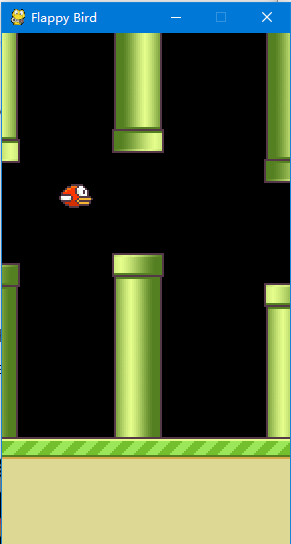